<p> Run a simulation of filling in a network based on the 7 de Septiembre neighborhood layout in Araijan </p>
<p>**(.inp and .config files already written)**</p>
<p> Below you see how to:</p>
<ul>
<li>Set boundary and initial conditions </li>
<li>Run a simulation until time T= 1200 s</li>
<li>plot time series of pressure head at different points in a single pipe</li>
<li>plot time series of pressure head at sample points in various pipes</li>
<li>plot space dependence of pressure head at a certain time</li>
<li>look at velocities</li>
<li>plot network layout</li>
</ul>

In [1]:
from __future__ import division
import sys
sys.path.append("/home/xin/pipes")   
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
#specify input files
fi = "/home/xin/pipes/indata/Xindata/myTtest-2.0.inp"    
fc = "/home/xin/pipes/indata/Xindata/myTtest-2.0.config" 
mtype = 1                             #model type. set =0 for uniform cross-section channel flow (has not been tested for awhile)
#create a network, n1 denotes the name of the network. It is like reading the file
n1 = PyNetwork(fi,fc,mtype)

In [3]:
#create time series Q(x=0, t) = q0 for t<T/2, 0 for t>=T/2
q0 = 0.3 #inflow boundary value (m^3/s), used to create the Q0 vector
M = n1.M   #number of time steps
print M
T = n1.T   #simulation length (in seconds)
Q0 = q0*np.ones(M+1)    #This is the actual inflow,q is only used to create Q0 vector        

#boundary condition for junction 0 (at the left end of pipe 0)
n1.setbVal(0,Q0)
p1 = PyPipe_ps(n1.Ns[0], n1.Ds[0],n1.Ls[0], M, n1.a[0])
p_head = p1.Eta(0.25*0.25*3.14,True)/9.81/(0.25*0.25*3.14)
print "When the pipe is full, the pressure head is", p_head, "m"

A00 = 1e-4*np.ones(n1.Ns[0])
Q00 = 5e-6*np.ones(n1.Ns[0])
for i in xrange(3):
    n1.setIC(i,A00,Q00)
'''
h0 = p1.AofH(1.5,False)                         # Area when H=10m
A00 = h0*np.ones(n1.Ns[0])                  # n1.Ns[0]-number of grids in pipe 0. So all the grids in pipe 0 have the same area h0
Q00 = Q0[0]*np.ones(n1.Ns[0])
n1.setIC(0,A00,Q00)                       # set the IC of pipe 0
'''
print 'the velocity is',q0/(n1.Ds[0]**2*pi/4),'m/s'
print "the slot width in pipe 2 is:",9.81*(n1.Ds[2]**2*pi/4)/(n1.a[0]**2)

50000
When the pipe is full, the pressure head is 0.171627472181 m
the velocity is 1.06103295395 m/s
the slot width in pipe 2 is: 4.81547248933e-05


In [ ]:
'''
A0 = np.zeros(M+1)
n1.setbVal(0,A0)
n1.setbVal(1,A0)
n1.setbVal(2,A0)
'''

In [ ]:
# uncomment line below to take a look at initial conditions before starting simulation
#n1.showCurrentData()
#plotNetworkLayout (xs, ys, conns, ls, Np)    # must combine with code lines below
#plotNetworkLayout(xs,ys,conns,ls,Np)
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np= shape(conns) [0]
%pylab notebook
plotNetworkLayout (xs, ys, conns, ls, Np) 
n1.showLayout()

In [ ]:
############ Only single running, for continuous and control of orifice opening ratio, see below

#Run the simulation!
dt = T/float(M)#time step
V0 = n1.getTotalVolume()
n1.runForwardProblem(dt)
print 'finished'


#----------------------------------------------------------------------------
# Calculate Pressure Head Difference 
#----------------------------------------------------------------------------
# Define a function to get time average to suppress oscillation

# P is the pressure that should be averaged over time
# Mi is how many time steps you want to average 
# dt is the initital time step size
def t_average(P, Mi, dt):
    n = int(len(P[:-1])/Mi)    # Totally M steps in P{:-1], n=M/Mi, n should be an integer
    x = []          
    P_new = []
    for i in xrange(n):
        P_new.append(np.average(P[i*Mi:(i+1)*Mi-1]))
        x.append((i+0.5)*Mi*dt)
    return x, P_new
#--------------------------------------------------------------
Mi = 2500    
print "Now the delta t is ", Mi*dt
#-------------------------------------------------------------


P0 = n1.pressureTimeSeries(0,n1.Ns[0]-1) 
P1 = n1.pressureTimeSeries(1,0)
P2 = n1.pressureTimeSeries(2,0)
t = linspace(0,n1.T, n1.M+1)
# Pressure Head difference dP1 = P0 - P1
dP1 = [P1[i]-P0[i] for i in xrange(len(P0))]
dP2 = [P2[i]-P0[i] for i in xrange(len(P0))]
print "dP1 finally =",dP1[-1]
print "dP2 finally =",dP2[-1]
fig = plt.figure(figsize= (10,5))
#plot(t,dP1, label = 'P1-P0')
#plot(t,dP2, label = 'P2-P0')

x0, P0 = t_average(P0, Mi, dt)
x1, P1 = t_average(P1, Mi, dt)
x2, P2 = t_average(P2, Mi, dt)
plot(x0,P0, label = 'P0')
plot(x1,P1, label = 'P1')
plot(x2,P2, label = 'P2')
legend()
xlabel("time")
ylabel("Pressue Head (m)")
#plt.ylim(-0.5,0.5)

#----------------------------------------------------------------------------
# Calculate Q1, Q2 distribution
#----------------------------------------------------------------------------
# get pipe (A,Q)data
qh0 = n1.qhist(0)
qh1 = n1.qhist(1)
qh2 = n1.qhist(2)
N = n1.Ns[1]
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)
Qext1 = [qh1[idx_t(1,N+1,it,N)] for it in xrange(n1.M+1)]
Qext2 = [qh2[idx_t(1,N+1,it,N)] for it in xrange(n1.M+1)]

x4, Qext1 = t_average(Qext1, Mi, dt)
x5, Qext2 = t_average(Qext2, Mi, dt)

print "Q1 finally =",Qext1[-1], "Percentage =", Qext1[-1]/q0
print "Q2 finally =",Qext2[-1],"Percentage =", Qext2[-1]/q0
fig = plt.figure(figsize= (10,5))
plot(x4,Qext1, label = 'Pipe 1 outflow')
plot(x5,Qext2, label = 'Pipe 2 outflow')
legend()
xlabel("time")
ylabel("flux(m^3/s)")
plt.ylim(0, 0.3)


print "Pressure Head in Pipe 0 is: ",P0[-1], "m"

In [4]:
############### Set Parameters for loop ###########################
T_total = 1000
###################################################################

# i = 0 means A, i=1 means Q
# j means the grid we are currently looking at, 1<=j<=N
# n means time step 
# N means the grid number in this certain pipe
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

def SetPipeIC (n1, i, H, left, right):
    L = n1.Ls[i]
    N = n1.Ns[i]
    D = n1.Ds[i]
    dx = L/N
    diff = (right-left)/N
    pipe = PyPipe_ps(N,D,L,n1.M,n1.a[0])
    A = []
    A_crt = 1e-4
    Q_crt =5e-5
    for k in xrange(N):
        current = left + (k+1/2)*diff
        deltaH = H - current
        if deltaH <= pipe.HofA(A_crt, False):
            A.append(A_crt)
        else:
            A.append( pipe.AofH(deltaH, True) )
    Q = Q_crt*np.ones(N)
    n1.setIC(i, A, Q)


# conn: np.ndarray
#       Nedgesx2 array of ints. Row i = [start node, end node] for pipe i.
pipe_number = len(n1.conn)
model_number = int(T_total/T)
dt = T/float(M)
# Store all the pressure head data before T
P0 = [] 
# Store all the pressure head data after T
P1 = []  
# Store all th pressure head data at the beginning of the branch
P2 = []
# Store the IC condition for each round of simulation
# ICs = { pipe: [ [A],[Q] ] }, therefore A = ICs[pipe][0], Q = ICs[pipe][1] 
ICs = {}
for k in xrange(model_number):
    n1.setbVal(0,Q0) 
    frac = 0.6            #############  Orifice Opening Ratio ###############
    Open1s = frac*n1.Ds[1]*np.ones(M+1)
    n1.setbVal(1,Open1s)
    Open2s = frac*n1.Ds[2]*np.ones(M+1)
    n1.setbVal(2,Open2s)
    if k != 0:
        t1 = time.time()
        for pipe in xrange(pipe_number):
            n1.setIC(pipe, ICs[pipe][0], ICs[pipe][1])
        n1.runForwardProblem(dt)
        t2 = time.time()
    else:
        t1 = time.time()
        n1.runForwardProblem(dt)
        t2 = time.time()
    print 'Piece %d of %d, running time = %ds'%(k+1, model_number, t2-t1)
    
    #### Reset IC for next round of simulation
    for pipe in xrange(pipe_number):
        qh = n1.qhist(pipe)
        N = n1.Ns[pipe]
        A = [qh[idx_t(0, j, M, N)] for j in xrange(1,N+1)]
        Q = [qh[idx_t(1, j, M, N)] for j in xrange(1,N+1)]
        ICs.update({pipe: [A, Q]})
    
    #### Collect data from this round of results
    #qh0 = n1.qhist(0)
    qh1 = n1.qhist(1)
    qh2 = n1.qhist(2)
    if len(P1)>0: 
        # Cut the last number since the begining and the end are overlaped
        P0 = np.concatenate((P0[:-1], n1.pressureTimeSeries(0,n1.Ns[0]-1)), axis = 0)  #One grid before the last one 
        P1 = np.concatenate((P1[:-1], n1.pressureTimeSeries(1,0)), axis = 0)
        P2 = np.concatenate((P2[:-1], n1.pressureTimeSeries(2,0)), axis = 0)
        Q1_current = [qh1[idx_t(1,n1.Ns[1]+1,it,n1.Ns[1])] for it in xrange(n1.M+1)]
        Q2_current = [qh2[idx_t(1,n1.Ns[2]+1,it,n1.Ns[2])] for it in xrange(n1.M+1)]
        Qext1 = np.concatenate( (Qext1[:-1], Q1_current), axis = 0)
        Qext2 = np.concatenate( (Qext2[:-1], Q2_current), axis = 0)
    else:
        P0 = n1.pressureTimeSeries(0,n1.Ns[0]-1) 
        P1 = n1.pressureTimeSeries(1,0)
        P2 = n1.pressureTimeSeries(2,0)
        Qext1 = [qh1[idx_t(1,n1.Ns[1]+1,it,n1.Ns[1])] for it in xrange(n1.M+1)]
        Qext2 = [qh2[idx_t(1,n1.Ns[2]+1,it,n1.Ns[2])] for it in xrange(n1.M+1)] 
    n1.reset()  
    time.sleep(2)

Piece 1 of 10, running time = 66s
Piece 2 of 10, running time = 72s
Piece 3 of 10, running time = 72s
Piece 4 of 10, running time = 67s
Piece 5 of 10, running time = 68s
Piece 6 of 10, running time = 68s
Piece 7 of 10, running time = 69s
Piece 8 of 10, running time = 69s
Piece 9 of 10, running time = 69s
Piece 10 of 10, running time = 69s


Now the delta t is  40.0


<IPython.core.display.Javascript object>


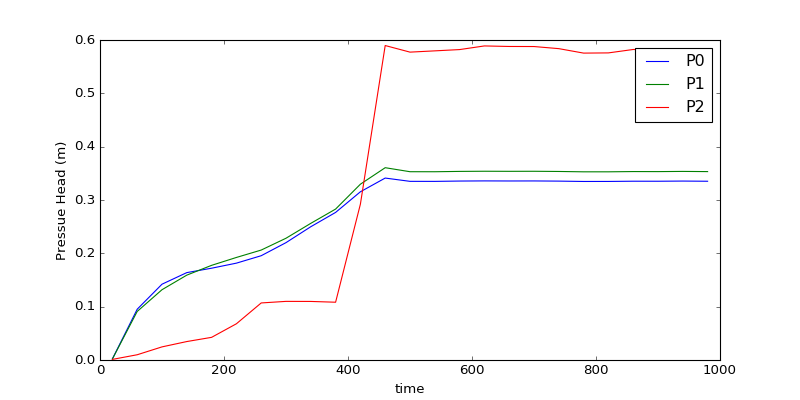

Q1 finally = 0.255181230137 Percentage = 0.850604100457
Q2 finally = 0.0440335071278 Percentage = 0.146778357093


<IPython.core.display.Javascript object>


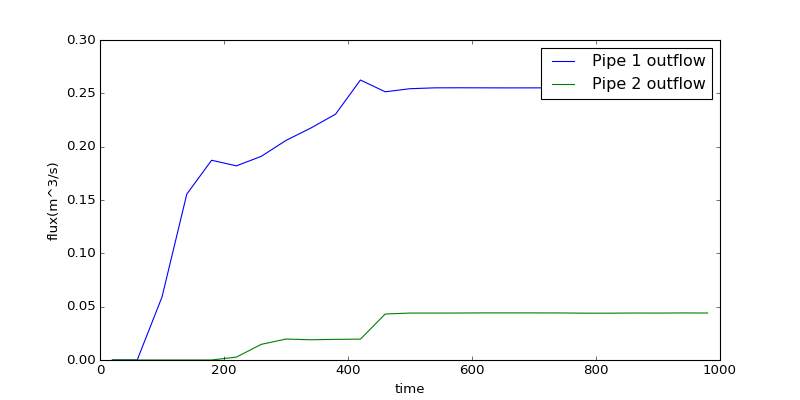

Pressure Head in Pipe 0 is:  0.335162623992 m


In [5]:
#----------------------------------------------------------------------------
# Calculate Pressure Head Difference 
#----------------------------------------------------------------------------
# Define a function to get time average to suppress oscillation

# P is the pressure that should be averaged over time
# Mi is how many time steps you want to average 
# dt is the initital time step size
def t_average(P, Mi, dt):
    n = int(len(P[:-1])/Mi)    # Totally M steps in P{:-1], n=M/Mi, n should be an integer
    x = []          
    P_new = []
    for i in xrange(n):
        P_new.append(np.average(P[i*Mi:(i+1)*Mi-1]))
        x.append((i+0.5)*Mi*dt)
    return x, P_new
#--------------------------------------------------------------
Mi = 20000    
print "Now the delta t is ", Mi*dt
#-------------------------------------------------------------

fig = plt.figure(figsize= (10,5))
x0, P0n = t_average(P0, Mi, dt)
x1, P1n = t_average(P1, Mi, dt)
x2, P2n = t_average(P2, Mi, dt)
plot(x0,P0n, label = 'P0')
plot(x1,P1n, label = 'P1')
plot(x2,P2n, label = 'P2')
legend()
xlabel("time")
ylabel("Pressue Head (m)")
#plt.ylim(-0.5,0.5)

#----------------------------------------------------------------------------
# Calculate Q1, Q2 distribution
#----------------------------------------------------------------------------
x4, Qext1n = t_average(Qext1, Mi, dt)
x5, Qext2n = t_average(Qext2, Mi, dt)

print "Q1 finally =",Qext1n[-1], "Percentage =", Qext1n[-1]/q0
print "Q2 finally =",Qext2n[-1],"Percentage =", Qext2n[-1]/q0
fig = plt.figure(figsize= (10,5))
plot(x4,Qext1n, label = 'Pipe 1 outflow')
plot(x5,Qext2n, label = 'Pipe 2 outflow')
legend()
xlabel("time")
ylabel("flux(m^3/s)")
#plt.ylim(0, 0.3)


print "Pressure Head in Pipe 0 is: ",P0n[-1], "m"

In [ ]:
M = n1.M
a = n1.a[0]
p0 = PyPipe_ps(n1.Ns[1], n1.Ds[1],n1.Ls[1], M, a)
p6 = PyPipe_ps(n1.Ns[2], n1.Ds[2],n1.Ls[2], M, a)
print p0.AofH(0.36, True)
print p6.AofH(0.15, True)
print p0.HofA(0.02, False)
print p6.HofA(0.00128, False)
#print p0.pbar(A0, False), p6.pbar(A6, False) , p0.HofA(0.290475, True), p0.AofH(0.0729*0.83, True)

In [ ]:
# Display the inflow and outflow for each pipe (m^3)  (ALl PIPES IN MODEL)


# Get Q of two ends of each pipe
Q = []
Mstep=1
#pipe_interest=[0]
pipe_interest=range(0,3)   
'''Here I redefine the pipe_interest vector'''

for i in range(len(pipe_interest)):
    Q_pipefix = [] 
    Q_start=[]
    Q_end=[]
    for m in xrange(0,n1.M,Mstep) :
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j)
        #Q_start.append(qh[idx_t(1,1,m,N)])   # Q1 (since qhist include ghost cell, so 0 and N+1 is the value of ghost cell)
        #Q_end.append(qh[idx_t(1,N,m,N)])     # QN
        Q_start.append(qh[idx_t(0,0,m,N)])   # Q1 (since qhist include ghost cell, so 0 and N+1 is the value of ghost cell)
        Q_end.append(qh[idx_t(1,N+1,m,N)])     # QN
    Q_pipefix.append(Q_start)
    Q_pipefix.append(Q_end)
    Q.append(Q_pipefix)
xt = np.linspace(0, n1.M*dt, n1.M/Mstep)
endorstart=['start','end']
for i in range(len(pipe_interest)):
    plt.figure(figsize= (10,4))                # same pipe on same figure
    for j in range(0,2):  
        #figsize = (15,5)                        # plot on same figure           
        #plt.figure(figsize= (15,5))             # plot on different figures
        plot(xt,Q[i][j], lw = 1,label = 'pipe %d, %s'%(pipe_interest[i],endorstart[j]))
        legend(bbox_to_anchor=(0.7, 0.3), loc=2, borderaxespad=0.)   #legend will be placed out of box and cannot be shown
        #legend()
        xlabel('time (s)')
        ylabel('flux (m^3/s)')
        title('Flux in pipe %d'%pipe_interest[i])
        plt.ylim(0,0.3)

# calculate inflow and outflow, i means pipe number, j means start or end, time means time in vector  
delta_t=Mstep*dt
Q_total=[]
for i in range(len(pipe_interest)):
    Q_total_pipefix=[]
    for j in range(0,2):
        Q_sum=0
        for time in range(len(Q[i][j])):
            Q_sum += Q[i][j][time]*delta_t
        Q_total_pipefix.append(Q_sum)
        print 'Pipe %d during %d s have total flow: %.3f m^3 (%s node)'%(pipe_interest[i],n1.T,Q_sum,endorstart[j])
    V_dif = Q_total_pipefix[0]- Q_total_pipefix[1]
    print V_dif
    Q_total.append(Q_total_pipefix)


# Display mass balance for each junction

#******************************************************************************************
#The following three list must corresponds to each other 
JunNode=[1]
Pipejun_in=[[0]]
Pipejun_out=[[1,2]]
#******************************************************************************************


assert (len(Pipejun_in)==len(Pipejun_out)),"Different dimensions of Pipejun_in and Pipejun_out!"

# Create x axis
xt = np.linspace(0, n1.M*dt, n1.M/Mstep)

# Q[i][j][k]   i means pipe number, j means start or end, k means time in vector 
for i in xrange(len(Pipejun_in)):
    Qjun_dif = []
    print len(Q[0])
    for k in xrange(len(Q[0][1])):
        Qinflow = 0
        Qoutflow = 0
        for j1 in Pipejun_in[i]:
            Qinflow += Q[j1][1][k]
        for j2 in Pipejun_out[i]:
            Qoutflow += Q[j2][0][k]
        Qjun_dif.append(Qinflow-Qoutflow)
    plt.figure(figsize= (10,4)) 
    plot(xt,Qjun_dif)   
    xlabel('t(s)')
    ylabel('Flux difference (m^3/s)')
    title('Junction %d Mass Conservation (Qin-Qout)'%JunNode[i])


In [ ]:
from matplotlib import animation
#*********************************************************************************
pipe_interest=[0,2]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=n1.T               # unit: s
#*********************************************************************************

# animation already imported above
plt.ion()
plt.show()

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length,pipe_length+n1.Ls[j],n1.Ns[j])
    x_interest.append(x)
    pipe_length=pipe_length+n1.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)


#create initial figure
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(0, 0.8)
lines = [plt.plot([], [])[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest))



pipe_length = 0
for pipe in pipe_interest:
    p0 = PyPipe_ps(n1.Ns[pipe], n1.Ds[pipe],n1.Ls[pipe], M, n1.a[0])
    A0 = n1.Ds[pipe]*n1.Ds[pipe]/4*3.14
    H_full = p0.Eta(A0,True)/9.81/A0 
    if pipe == 0:
        x = np.linspace(pipe_length,pipe_length+n1.Ls[pipe],n1.Ns[pipe])
        plt.plot(x,[H_full]*len(x),'g--',label= 'pipe %d full'%(pipe))
        pipe_length += n1.Ls[pipe]
    else:
        x = np.linspace(pipe_length,pipe_length+n1.Ls[pipe],n1.Ns[pipe])
        plt.plot(x,[H_full]*len(x),'g--',label="pipe %d full"%(pipe))
        A_open = p0.AofH(frac*n1.Ds[pipe], False)                                 # farc defined in the running cell
        H_open= p0.Eta(A_open,False)/9.81/A_open
        print frac*n1.Ds[pipe],A_open, H_open
        plt.plot(x,[H_open]*len(x),'r--',label = "pipe %d opening"%(pipe))
legend(bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.)
# initialization function: plot the background of each frame



def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)
H_interest=[]



def animate(index):
    H_interest_tfixed = []
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    H_interest_combine = np.concatenate(H_interest[index],axis =0)
    line.set_data(x_interest_combine,H_interest_combine)
    plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=3, blit=False)
plt.show()
"""Save Anna Result"""
#anim.save('/home/xin/pipes/examples/output_data/MyTtest/AnnaCode %s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))
"""Save My Result"""
#anim.save('/home/xin/pipes/examples/output_data/MyTtest/FieldCalibrate/%s steady.mp4'%str(pipe_interest))
#anim.save('/home/xin/pipes/examples/output_data/MyTtest/Karney_Improvement/Anna+B_1.11_6_open0.8/D2=%s/%s %.0f-%.0f s.mp4'%(str(n1.Ds[2]),str(pipe_interest),t_start,t_end))

In [ ]:
m32gal = 264.172   #conversion factor, m^3 to gallons
m2psi = 1.42       #conversion factor, m of pressure head to psi
mdx = min([n1.Ls[i]/n1.Ns[i] for i in range(n1.Nedges)])
#print timing information
print "Simulated time T = %f s" %n1.T
print "Solve time = %f  s" %n1.solve_time
print "dt = %f" %dt
print "inflow volume = %.2f gallons" % ((n1.getTotalVolume()-V0)*m32gal)
print "pressure wave speed is %f m/s"% (max(n1.a))
print "CFL = 1/(dx/dt)*(max wave speed) = %f" % (max(n1.cmax)*dt/mdx)

In [ ]:
# i = 0 means A, i=1 means Q
# j means grid number [0,N+1] including two grid cells
# n means time step
# N means grid number of this pipe
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)
H1 = n1.pressureSpaceSeries(0,int(M))  
H2 = n1.pressureSpaceSeries(1,int(M)) 
H3 = n1.pressureSpaceSeries(2,int(M)) 
print len(H1) # so H0 only contains real grid values
print H1[-1],H2[0],H3[0]

# print the pressure head at the junction
#print '0:',p1.pbar(0.151917,True),"1,2:",p1.pbar(0.162652,False)

# get pipe (A,Q)data
qh1 = n1.qhist(0)
qh2 = n1.qhist(1)
qh3 = n1.qhist(2)
N = n1.Ns[1]

# For pipe 1, print Qin,Ain,Qext, Aext (right end)
M = n1.M/2
Ain1 = qh1[idx_t(0,N,int(M),N)]
Aext1 = qh1[idx_t(0,N+1,int(M),N)]
Qin1 = qh1[idx_t(1,N,int(M),N)]
Qext1= qh1[idx_t(1,N+1,int(M),N)]
print "The cell value of pipe 1:",Ain1,Qin1,Aext1,Qext1,p1.Eta(Ain1,False)/9.81/Ain1

# For pipe 2, print Qin,Ain,Qext, Aext (left end)
Ain2 = qh2[idx_t(0,1,int(M),N)]
Aext2 = qh2[idx_t(0,0,int(M),N)]
Qin2 = qh2[idx_t(1,1,int(M),N)]
Qext2= qh2[idx_t(1,0,int(M),N)]
print "The cell value of pipe 2:",Ain2,Qin2,Aext2,Qext2,p1.Eta(Ain2,False)/9.81/Ain1

# For pipe 3, print Qin,Ain,Qext, Aext (left end)
Ain3 = qh3[idx_t(0,1,int(M),N)]
Aext3 = qh3[idx_t(0,0,int(M),N)]
Qin3 = qh3[idx_t(1,1,int(M),N)]
Qext3= qh3[idx_t(1,0,int(M),N)]
print "The cell value of pipe 3:",Ain3,Qin3,Aext3,Qext3,p1.Eta(Ain3,False)/9.81/Ain1

print len(qh1)



In [ ]:
#*********************************************************************************
pipe_interest=[0,1,2]
t_delta=1              # unit: s
t_start=0              # unit:s
t_end= n1.T               # unit: s
#*********************************************************************************

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(0,n1.Ls[j],n1.Ns[j])
    x_interest.append(x)

#create initial figure
from matplotlib import animation
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.05, 0.8)
lines = [plt.plot([], [],label='pipe {}'.format(pipe_interest[i]))[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)

def animate(index): 
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        line.set_data(x_interest[i],Hx)
        plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
        #line.set_label('pipe %d t=%.2f s'%(j,(dt*(M_start+index*Mi_draw))))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=3, blit=True)
plt.legend(bbox_to_anchor=(0.85, 1), loc=2, borderaxespad=0.)
plt.show()
"""Save My Result"""
#anim.save('/home/xin/pipes/examples/output_data/MyTtest/Karney_Improvement/Anna+B_1.11_6_open0.8/D2=0.2/%s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))

#anim = animation.FuncAnimation(fig, animate, init_func=init,frames=3, interval=20, blit=True)
#anim.save("basic_animation.mp4")
#plt.show()
    # time.sleep(0.01)
    # bbox_to_anchor: the bbox that the legend will be anchored, 1.05 means 1.05 times of figure length
    # borderaxespad: the pad between the axes and legend border
# Display the inflow and outflow for each pipe (m^3)  (ALl PIPES IN MODEL)




In [ ]:
# Calculated Outflow
#****************************************************************************
t_interval = 1                  # unit: s
pipe_interest = range(0,3)      # Pipes you want to know 
#****************************************************************************

def get_gradient(distance,pressure_series):
    gradient = []
    for k in xrange(len(pressure_series)-1):
        gradi = (pressure_series[k]-pressure_series[k+1])/distance
        #if gradi == 0:                     # 0 is a const to reflect initial gradient
            #return 0
        gradient.append(gradi)
    return gradient

Mi_draw = int(t_interval/dt)
average_all=[]
deviation_all=[]
for i in xrange(len(pipe_interest)):
    pipe_number = pipe_interest[i]
    dx = n1.Ls[pipe_number]/n1.Ns[pipe_number]
    t_dev=[]
    deviation = []
    average = []  
    for m in range(0,n1.M+1,Mi_draw):
        Hx = n1.pressureSpaceSeries(pipe_number,m)
        gradient = get_gradient(dx,Hx[2:-2])           # eliminate first two grids and the last grid
        ave = np.mean(gradient)
        gradient = [gradient[loc] / ave for loc in range(len(gradient))]  # normalize gradient
        deviation.append(np.std(gradient))
        average.append(ave)
        t_dev.append(m*dt)
    average_all.append(average)
    deviation_all.append(deviation)
    



# average_all [pipe][time_step]
# Using the average gradient along the pipe to get [This is the equation used in the steady state, so try it]
U_interest=[]
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

g = 9.81
pipe_interest = range(0,3)
plt.figure(figsize= (12,5)) 
for pipe in pipe_interest:
    mean_gradient = average_all[pipe]
    Q_pipefixed = []
    for time in xrange(len(mean_gradient)):
        #using the equation of pressurized short pipe, assume that the pipe is full
        # Q = miu*A*sqrt(2*g*(H2-H1))
        lambuda = 0.037
        miu = 1/sqrt(1+lambuda*n1.Ls[pipe]/n1.Ds[pipe]) # no obvious local loss, only frictional loss
        delta_head = mean_gradient[time]*(n1.Ns[pipe]-3)/n1.Ns[pipe]*n1.Ls[pipe]
        A = n1.Ds[pipe]**2/4*pi
        if delta_head<0:
            Q=-miu*A*sqrt(abs(2*g*delta_head))
        else:
            Q = miu*A*sqrt(abs(2*g*delta_head))
        Q_pipefixed.append(Q) 
    plt.plot(t_dev,Q_pipefixed,label='pipe%d'%pipe) 
    legend()
    plt.xlabel('t(s)')
    plt.ylabel('Q (m3/s)')
    #plt.title('v=%.1f,Pipe %s Outflow (from me)'%(v,str(pipe_interest)))
    #savefig('/home/xin/pipes/examples/output_data/EpipeFig/Outflow/Pipe %s Outflow (from me).png'%str(pipe_interest), bbox_inches='tight')

    
# Compare with Lieb's results from equation [just get Q_end from each pipe]
Q=[]
for i in range(len(pipe_interest)):
    Q_pipefix = [] 
    Q_end=[]
    for m in xrange(0,n1.M,Mi_draw) :
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j)
        Q_end.append(qh[idx_t(1,N-1,m,N)])     # QN
    Q_pipefix.append(Q_end)
    Q.append(Q_pipefix)
xt = np.linspace(0, n1.M*dt, n1.M/Mi_draw)
plt.figure(figsize= (12,5))             # plot on different figures
for i in range(len(pipe_interest)):   
        print len(xt),len(Q[i][0])
        plot(xt,Q[i][0], lw = 1,label = 'pipe %d'%(pipe_interest[i]))
        #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   #legend will be placed out of box and cannot be shown
        legend()
        xlabel('time (s)')
        ylabel('Q (m3/s)')
        #plt.title('v=%.1f,Pipe %s Outflow (from me)'%(v,str(pipe_interest)))
#savefig('/home/xin/pipes/examples/output_data/EpipeFig/Outflow/Pipe %s Outflow (from Libe).png'%str(pipe_interest), bbox_inches='tight')

In [ ]:
# Get inflow to the system and outflow from the system
#****************************************************************************
t_interval = 3.5*dt                  # unit: s
pipe_interest = range(0,3)      # Pipes you want to know 
#****************************************************************************

def get_gradient(distance,pressure_series):
    gradient = []
    for k in xrange(len(pressure_series)-1):
        gradi = (pressure_series[k]-pressure_series[k+1])/distance
        #if gradi == 0:                     # 0 is a const to reflect initial gradient
            #return 0
        gradient.append(gradi)
    return gradient

Mi_draw = int(t_interval/dt)

Q=[]
for i in range(len(pipe_interest)):
    Q_pipefix = [] 
    Q_end=[]
    for m in xrange(0,n1.M,Mi_draw) :
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j)
        if j == 0:
            Q_end.append(qh[idx_t(1,0,m,N)])
        else:
            Q_end.append(qh[idx_t(1,N-1,m,N)])     # QN
    Q_pipefix.append(Q_end)
    Q.append(Q_pipefix)
xt = np.linspace(0, n1.M*dt, n1.M/Mi_draw+1)
plt.figure(figsize= (12,5))             # plot on different figures
for i in range(len(pipe_interest)): 
        print len(xt),len(Q[i][0])
        plot(xt,Q[i][0], lw = 1,label = 'pipe %d'%(pipe_interest[i]))
        legend(bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.)   #legend will be placed out of box and cannot be shown
        #legend()
        plt.ylim(0, 0.3)
        xlabel('time (s)')
        ylabel('Q (m3/s)')
        #plt.title('v=%.1f,Pipe %s Outflow (from me)'%(v,str(pipe_interest)))
#savefig('/home/xin/pipes/examples/output_data/MyTtest/inflowq=0.25,v=1.27/Pipe %s Outflow (from Libe).png'%str(pipe_interest), bbox_inches='tight')

In [ ]:
# Water Volume changes in pipe with time

#*****************************************************************************
pipe_interest1=range(0,3)
#*****************************************************************************

print "The volume in each pipe is",(n1.Ds[0]**2*pi/4)*n1.Ls[0], "m^3"

# Get A of two ends of each pipe
A = [] # all time, all pipes, all A values in grids
M_total=n1.M+1
Mi_draw=100

for m in xrange(0,M_total,Mi_draw) :
    A_tfixed=[] # certain time, all pipes, all A values in grids
    for i in xrange(len(pipe_interest1)):
        j = pipe_interest1[i]
        N = n1.Ns[j]
        qh = n1.qhist(j) 
        Atemp=[]  #certain time, certain pipe, all A values in grids
        for k in xrange(1,N+1):
            Ak=qh[idx_t(0,k,m,N)]      
            Atemp.append(Ak)
        A_tfixed.append(Atemp)     
    A.append(A_tfixed)
        
#calculate total volumn, i means time, j means pipe number, distance means value of grids  
V_total=[]
for i in xrange(0,M_total,Mi_draw):
    V_total_tfix=[]
    for j in xrange(len(pipe_interest1)):
        V_sum=0
        pipe_number=pipe_interest1[j]
        delta_x=n1.Ls[pipe_number]/n1.Ns[pipe_number]
        for distance in xrange(len(A[int(i/Mi_draw)][j])):
            V_sum += A[int(i/Mi_draw)][j][distance]*delta_x
        V_total_tfix.append(V_sum)
        #print 'Pipe %d during %d s have total flow: %.3f m^3 '%(pipe_number,i*dt,V_sum)
    #print 'The total volumn at t=%d s are                      %.3f m^3'%(i*dt,sum(V_total_tfix))
    V_total.append(V_total_tfix)

xt1 = np.linspace(0, M_total*dt, M_total/Mi_draw)
plt.figure(figsize= (11,5))
title('Water Volume in Pipe ~ time')
xlabel('t(s)')
ylabel('V(m^3)')
for j in xrange(len(pipe_interest1)):
    pipe_number=pipe_interest1[j]
    V_total_pipefix=[]
    for i in xrange(1,M_total,Mi_draw):
        V_total_pipefix.append(V_total[int(i/Mi_draw)][j])
    plot(xt1,V_total_pipefix,label = 'pipe %d'%pipe_number)
    #plt.ylim(0,20)
    legend(bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.)



In [ ]:
#show time series at a sensor in the middle of each pipe in the network
# import a nice colormap
from matplotlib import cm
import matplotlib.colors as colors
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('hsv') )
fig = figure(figsize= (15,5))
t = linspace(0,T,M+1)
interesting = arange(0,Np) #pipes you are interested in (currently all)
interesting1 = array([0,1,2,4,6])
for i in interesting1: 
    #look at pressure time series in i^th pipe, pbar(A(X*, t)), where X* = L/2 for pipe length L, and t =0, dt, 2*dt,...dt*M
    P1 = n1.pressureTimeSeries(i,n1.Ns[i]/2-1) 
    plot(t,P1,color =scalarMap.to_rgba(i), label = "pipe %d" %i) 
legend(ncol=7, loc = (0,1))
ax = gca()
ax.set_xlabel('t (s)')
#xlabel('t(s)')
#ylabel('H(m)')
ax.set_ylabel('H (m)')

In [ ]:
#show pressure time series at different locations along the length of a single pipe
i = 1  #pipe number you want to look at
fig = figure(figsize= (15,5))
#new color map
xs = np.arange(1,n1.Ns[i]+1,4)           # all the grids, increment is 2
print xs
print len(xs)
cNorm  = colors.Normalize(vmin=0, vmax=xs[-1]+10)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean') )
t = np.linspace(0,n1.T,M+1)
for J in range(0,len(xs),3):
    cval = scalarMap.to_rgba(xs[J])
    dx = n1.Ls[i]/float(n1.Ns[i])
    P2 = n1.pressureTimeSeries(i,J)
    q=plot(t,P2,color =cval,label="x = %.1f"%(dx*xs[J]))
ax = gca()
ax.set_title('Pipe %d'%i)
ax.set_xlabel('t (s)')
ax.set_ylabel(r'$\bar{p}$ (m)')
#legend()
#legend(loc = 'upper left')
#savefig("../sensors_pipe%d.eps"%i, format='eps')

In [ ]:
#show how pressure profile varies in space at the end of the run 
i = 5  # pipe you want to look at
fig = figure(figsize= (10,5))
#m = M  #time slice you want to look at, the simulation only has M steps, so m here refers to the end of the simulation
for m in range(0,n1.M+1,6000):
    Px = n1.pressureSpaceSeries(i,m)
    x = linspace(0,n1.Ls[i],n1.Ns[i])
    plot(x,Px,label = 't=%.2f s'%(dt*m))
    # title('Pipe %d at time %.2f s'%(i,dt*m))
    legend()
    draw()
    xlabel('x')
    ylabel(r'$\bar{p}(m)$')
    fig = figure(figsize= (10,5))


In [ ]:
#plot network layout
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np = shape(conns)[0]
plotNetworkLayout(xs,ys,conns,ls,Np)

In [ ]:
# The following codes are only used to try python functions, the purpose is about learning python
plt.plot([1,2,3,4], [1,4,9,16], 'ro')
plt.axis([0, 6, 0, 20])
plt.show()


In [ ]:
help(gca)

In [ ]:

1*np.ones(2)

In [ ]:
# Continuous Pressure Head Display
from __future__ import division
import sys
sys.path.append("..")    
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time

#*********************************************************************************
pipe_interest=[2,3,9]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=3600               # unit: s
#*********************************************************************************

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(0,n1.Ls[j],n1.Ns[j])
    x_interest.append(x)

#create initial figure
from matplotlib import animation
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 400)
lines = [plt.plot([], [],label='pipe {}'.format(pipe_interest[i]))[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)

def animate(index): 
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n1.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        line.set_data(x_interest[i],Hx)
        plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
        #line.set_label('pipe %d t=%.2f s'%(j,(dt*(M_start+index*Mi_draw))))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=10, blit=True)
plt.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/T_junction_detection/pipe %s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))